# Lab 2: Final

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Ejercicios Lab Final

Se pide:

1) Implementar [Double DQN (DDQN)](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12389/11847).

2) Implementar [Dueling DDQN](https://arxiv.org/pdf/1511.06581.pdf).

3) Cambiar el entorno por uno nuevo a elección

**Comentar en un notebook lo realizado paso a paso, mostrando resultados parciales y finales. Y subirlo a un repositorio en GitHub** 

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import math
import numpy as np
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools
import torch
from torch import nn
from torch.nn import functional as F
from agents.utils.memory.ReplayMemory import ReplayMemory
from agents.utils.memory.Transition import Transition

## DQN - CartPole

In [2]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x

In [3]:
class DQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [4]:
agent = DQN(gym.make('CartPole-v0'), n_episodes=1000, debug=True)
scoresDQN, meanDQN = agent.run()

[Episode 0] - Mean reward 17.0.
[Episode 100] - Mean reward 70.54455445544555.
[Episode 200] - Mean reward 74.09950248756219.
[Episode 300] - Mean reward 74.9700996677741.
[Episode 400] - Mean reward 79.10473815461347.
[Episode 500] - Mean reward 76.79840319361277.
[Episode 600] - Mean reward 77.17138103161398.
[Episode 700] - Mean reward 77.7018544935806.
[Episode 800] - Mean reward 78.54556803995007.
[Episode 900] - Mean reward 81.10654827968924.
[Episode 999] - Mean reward 79.6.


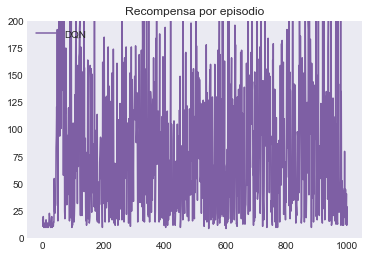

In [5]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDQN), label='DQN', c='#7e5fa4')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

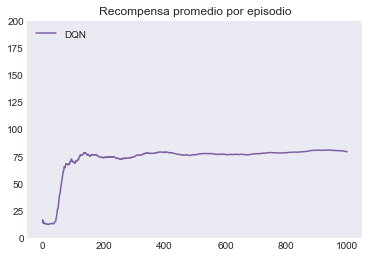

In [6]:
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## DDQN - CartPole

In [7]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x

In [8]:
class DDQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            #next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            #NUEVO CODIGO PARA DDQN
            _, next_state_actions = self.model(non_final_next_states).max(1, keepdim=True)
            next_state_values[non_final_mask] = self.target(non_final_next_states).gather(1, next_state_actions).squeeze() 
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values
        
        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [9]:
agent = DDQN(gym.make('CartPole-v0'), n_episodes=1000, debug=True)
scoresDDQN, meanDDQN = agent.run()

[Episode 0] - Mean reward 10.0.
[Episode 100] - Mean reward 53.71287128712871.
[Episode 200] - Mean reward 64.41293532338308.
[Episode 300] - Mean reward 63.51495016611295.
[Episode 400] - Mean reward 62.9501246882793.
[Episode 500] - Mean reward 60.231536926147704.
[Episode 600] - Mean reward 59.14808652246256.
[Episode 700] - Mean reward 58.534950071326676.
[Episode 800] - Mean reward 57.098626716604244.
[Episode 900] - Mean reward 57.43951165371809.
[Episode 999] - Mean reward 58.923.


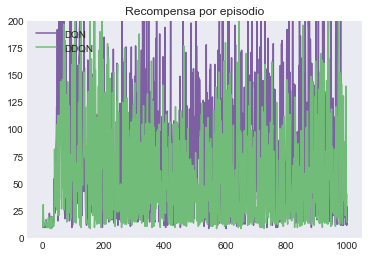

In [10]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(scoresDDQN), label='DDQN', c='#71bc78')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

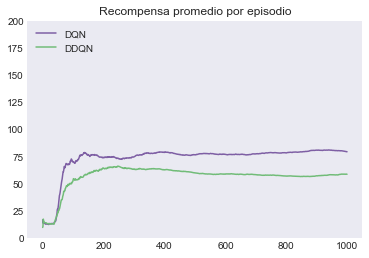

In [11]:
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(meanDDQN), label='DDQN', c='#71bc78')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## Dueling DDQN - CartPole

In [12]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        
        self.advantage = nn.Linear(_hidden_size, _output_size)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
      
        #NUEVO CODIGO PARA Dueling DDQN
        adv = F.relu(self.advantage(x))
        x = self.output(x)
        return x + adv - adv.mean()

In [13]:
class DuelingDDQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values
        
        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [14]:
agent = DuelingDDQN(gym.make('CartPole-v0'), n_episodes=1000, debug=True)
scoresDuelingDDQN, meanDuelingDDQN = agent.run()

[Episode 0] - Mean reward 8.0.
[Episode 100] - Mean reward 68.63366336633663.
[Episode 200] - Mean reward 72.56716417910448.
[Episode 300] - Mean reward 68.15946843853821.
[Episode 400] - Mean reward 70.94513715710723.
[Episode 500] - Mean reward 68.75249500998004.
[Episode 600] - Mean reward 68.90848585690516.
[Episode 700] - Mean reward 69.7475035663338.
[Episode 800] - Mean reward 69.6903870162297.
[Episode 900] - Mean reward 72.41287458379578.
[Episode 999] - Mean reward 75.019.


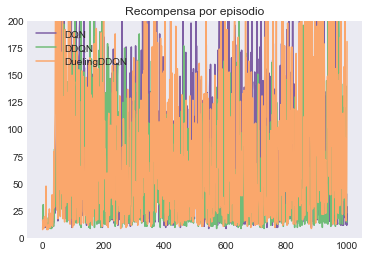

In [15]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(scoresDDQN), label='DDQN', c='#71bc78')
plt.plot(np.array(scoresDuelingDDQN), label='DuelingDDQN', c='#faa76c')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

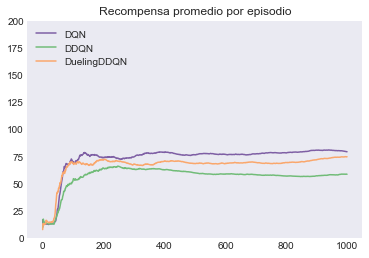

In [16]:
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(meanDDQN), label='DDQN', c='#71bc78')
plt.plot(np.array(meanDuelingDDQN), label='DuelingDDQN', c='#faa76c')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## DQN - MountainCar

In [25]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x

In [26]:
class DQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [27]:
agent = DQN(gym.make('MountainCar-v0'), n_episodes=1000, debug=True)
scoresDQN, meanDQN = agent.run()

[Episode 0] - Mean reward -200.0.
[Episode 100] - Mean reward -200.0.
[Episode 200] - Mean reward -200.0.
[Episode 300] - Mean reward -200.0.
[Episode 400] - Mean reward -200.0.
[Episode 500] - Mean reward -199.96207584830339.
[Episode 600] - Mean reward -199.9683860232945.
[Episode 700] - Mean reward -198.88587731811697.
[Episode 800] - Mean reward -197.78027465667915.
[Episode 900] - Mean reward -197.11320754716982.
[Episode 999] - Mean reward -197.399.


## DDQN - MountainCar

In [30]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x

In [31]:
class DDQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            #next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            #NUEVO CODIGO PARA DDQN
            _, next_state_actions = self.model(non_final_next_states).max(1, keepdim=True)
            next_state_values[non_final_mask] = self.target(non_final_next_states).gather(1, next_state_actions).squeeze() 
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values
        
        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [32]:
agent = DDQN(gym.make('MountainCar-v0'), n_episodes=1000, debug=True)
scoresDDQN, meanDDQN = agent.run()

[Episode 0] - Mean reward -200.0.
[Episode 100] - Mean reward -200.0.
[Episode 200] - Mean reward -200.0.
[Episode 300] - Mean reward -200.0.
[Episode 400] - Mean reward -199.91770573566086.
[Episode 500] - Mean reward -199.6546906187625.
[Episode 600] - Mean reward -199.71214642262896.
[Episode 700] - Mean reward -199.74465049928673.
[Episode 800] - Mean reward -198.8863920099875.
[Episode 900] - Mean reward -198.11209766925637.
[Episode 999] - Mean reward -198.097.


## Dueling DDQN - MountainCar

In [35]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        
        self.advantage = nn.Linear(_hidden_size, _output_size)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
      
        #NUEVO CODIGO PARA Dueling DDQN
        adv = F.relu(self.advantage(x))
        x = self.output(x)
        return x + adv - adv.mean()

In [36]:
class DuelingDDQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values
        
        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [37]:
agent = DuelingDDQN(gym.make('MountainCar-v0'), n_episodes=1000, debug=True)
scoresDuelingDDQN, meanDuelingDDQN = agent.run()

[Episode 0] - Mean reward -200.0.
[Episode 100] - Mean reward -200.0.
[Episode 200] - Mean reward -200.0.
[Episode 300] - Mean reward -200.0.
[Episode 400] - Mean reward -200.0.
[Episode 500] - Mean reward -199.7684630738523.
[Episode 600] - Mean reward -199.25790349417636.
[Episode 700] - Mean reward -198.5549215406562.
[Episode 800] - Mean reward -198.31086142322098.
[Episode 900] - Mean reward -197.4583795782464.
[Episode 999] - Mean reward -197.212.


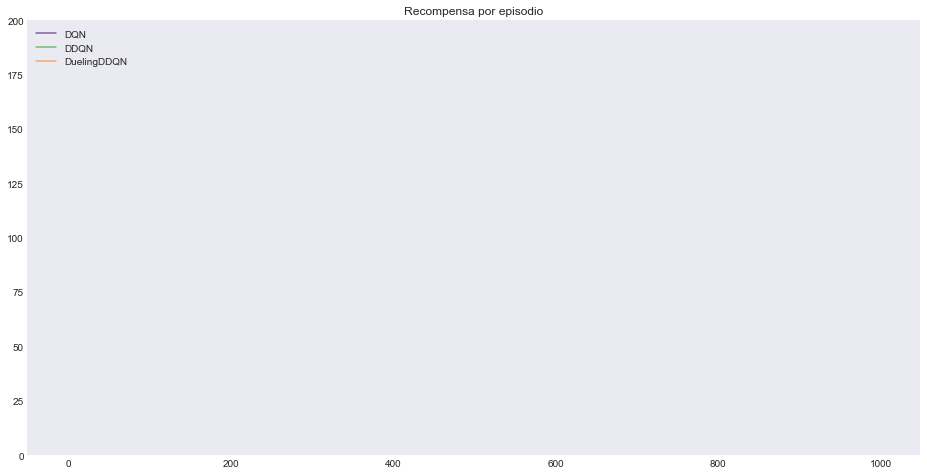

In [38]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(scoresDDQN), label='DDQN', c='#71bc78')
plt.plot(np.array(scoresDuelingDDQN), label='DuelingDDQN', c='#faa76c')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

Para CartPole, DQN, que se encarga de sobreestimar los reward, es quien ha presentado los mejores reward promedio, y prácticamente valores solo en ascenso. Se observa que la base inicial es más alta que con los demás métodos. Con DuelingDDQN, quien sabe identificar estados más y menos valiosos, comienza con valores bajos pero llega a igualarse con DQN al aumentar las repeticiones, obteniendo así altos valores. Sin embargo en eset juego DDQN se mantiene. En todos los casos se observa un estancamiento (o muy leve crecimiento) a medida que tenemos más corridas.
Como segunda prueba elegimos Mou1ntainCar. En este caso no se observan grandes diferencias en los resultados.
Cabe destacar que por tiempos de corrida la cantidad de repeticiones es extremadamente pequeña.